# Experiments on MobileNet

In [2]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import pandas as pd
import os
from skimage import io
import torch
from skimage import color
import pickle
from copy import deepcopy
from sklearn.metrics import roc_auc_score, f1_score

## Check if Running on GPU and Define Training Loop

In [3]:
if torch.cuda.is_available:
    print('Running on GPU.')
    print(torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found. Running on CPU.')
    device = torch.device('cpu')

Running on GPU.
Quadro RTX 8000


In [4]:
def train_model(model, dataloader, optimizer, loss_fn, num_epochs = 50, verbose = False):
    f1_dict = {'train':[],'validate':[]}
    loss_dict = {'train':[],'validate':[]}
    best_loss = np.inf
    best_f1 = 0
    best_acc = 0
    phases = ['train','validate']
    since = time.time()
    for i in range(num_epochs):
        print('Epoch: {}/{}'.format(i, num_epochs-1))
        print('-'*10)
        for phase in phases:
            running_correct = 0
            running_loss = 0
            running_total = 0
            all_preds = []
            all_labels = []
            if phase == 'train':
                model.train()
                for data in dataloader[phase]:
                    optimizer.zero_grad()
                    image = data['x'].to(device)
                    label = data['y'].to(device)
                    logits = model(image) #.logits
                    loss = loss_fn(logits, label)
                    _, preds = torch.max(logits, dim = 1)
                    num_imgs = image.size()[0]
                    running_correct += torch.sum(preds == label).item()
                    running_loss += loss.item()*num_imgs
                    running_total += num_imgs
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(label.cpu().numpy())
                    
                    loss.backward()
                    optimizer.step()
                    
                epoch_acc = float(running_correct/running_total)
                epoch_loss = float(running_loss/running_total)
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                if verbose or (i%10 == 0):
                    print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f} F1: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_f1))

                f1_dict[phase].append(epoch_f1)
                loss_dict[phase].append(epoch_loss)

            # Auxiliary classifier is turned off during evaluation
            else:
                model.eval()
                with torch.no_grad():
                    for data in dataloader[phase]:
                        image = data['x'].to(device)
                        label = data['y'].to(device)
                        logits = model(image)
                        loss = loss_fn(logits, label)
                        _, preds = torch.max(logits, dim = 1)
                        num_imgs = image.size()[0]
                        running_correct += torch.sum(preds == label).item()
                        running_loss += loss.item()*num_imgs
                        running_total += num_imgs
                        all_preds.extend(preds.cpu().numpy())
                        all_labels.extend(label.cpu().numpy())
        
                epoch_acc = float(running_correct/running_total)
                epoch_loss = float(running_loss/running_total)
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                if verbose or (i%10 == 0):
                    print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f} F1: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_f1))

                f1_dict[phase].append(epoch_f1)
                loss_dict[phase].append(epoch_loss)
                if epoch_f1 > best_f1:
                    best_loss = epoch_loss
                    best_model_wts = deepcopy(model.state_dict())
                    best_f1 = epoch_f1
                    best_acc = epoch_acc

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Selected model val acc: {:4f} Selected model val F1: {:4f}'.format(best_acc, best_f1))
    
    model.load_state_dict(best_model_wts)
    
    return model, f1_dict, loss_dict

## Small Sample of HAM10000

In [5]:
# Get random small sample of the data
train_df_path = 'train.csv'
val_df_path = 'validation.csv'
test_df_path = 'test.csv'

train_df = pd.read_csv(train_df_path)
val_df = pd.read_csv(val_df_path)
test_df = pd.read_csv(test_df_path)

train_sample = train_df.sample(frac=0.15, random_state=48)
val_sample = val_df.sample(frac=0.15, random_state=48)
test_sample = test_df.sample(frac=0.15, random_state=48)

print('\nSample Train set class distribution:')
print(train_sample['Class'].value_counts(normalize=True))
print(train_sample['Class'].value_counts(normalize=False))
print('\nSample Validation set class distribution:')
print(val_sample['Class'].value_counts(normalize=True))
print(val_sample['Class'].value_counts(normalize=False))
print('\nSample Test set class distribution:')
print(test_sample['Class'].value_counts(normalize=True))
print(test_sample['Class'].value_counts(normalize=False))


Sample Train set class distribution:
Class
5    0.690995
2    0.106161
4    0.104265
1    0.047393
0    0.026540
3    0.015166
6    0.009479
Name: proportion, dtype: float64
Class
5    729
2    112
4    110
1     50
0     28
3     16
6     10
Name: count, dtype: int64

Sample Validation set class distribution:
Class
5    0.648649
4    0.114865
2    0.074324
0    0.060811
1    0.047297
6    0.027027
3    0.027027
Name: proportion, dtype: float64
Class
5    96
4    17
2    11
0     9
1     7
6     4
3     4
Name: count, dtype: int64

Sample Test set class distribution:
Class
5    0.698997
2    0.103679
1    0.066890
4    0.066890
0    0.030100
6    0.023411
3    0.010033
Name: proportion, dtype: float64
Class
5    209
2     31
1     20
4     20
0      9
6      7
3      3
Name: count, dtype: int64


In [13]:
# Save to CSV
train_sample.to_csv('sample_train.csv', index=False)
val_sample.to_csv('sample_validation.csv', index=False)
test_sample.to_csv('sample_test.csv', index=False)

## Dataset and Dataloader

In [6]:
def class_label(label):
    if label == 'akiec':
        label = 0
    elif label == 'bcc':
        label = 1
    elif label == 'bkl':
        label = 2
    elif label == 'df':
        label = 3
    elif label == 'mel':
        label = 4
    elif label == 'nv':
        label = 5
    elif label == 'vasc':
        label = 6
    return label

# Cropped for MobileNetV2, Non-augmented data
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(299),  
    transforms.CenterCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

validation_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(299), 
    transforms.CenterCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


class HAM10000Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = load_data_and_get_class(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 1]+'.jpg')
        
        image = io.imread(img_name)
        if len(image.shape) > 2 and image.shape[2] == 4:
            image = image[:,:,0]
            
        image_class = self.data_frame.iloc[idx, -1]
        
        if self.transform:
            image = self.transform(image)

        sample = {'x': image, 'y': image_class}

        return sample

def load_data_and_get_class(path_to_data):
    data = pd.read_csv(path_to_data)
    data['Class'] = data['dx'].apply(class_label)
    return data

## Learning Rate/Batch Size Tuning

In [7]:
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=7):
        super(MobileNetV2, self).__init__()
        self.mobilenet_v2 = models.mobilenet_v2(weights='IMAGENET1K_V1')
        num_ftrs = self.mobilenet_v2.classifier[-1].in_features
        self.mobilenet_v2.classifier[-1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.mobilenet_v2(x)

In [8]:
batch_sizes = [16, 32, 64]
learning_rates = [0.00001, 0.0001, 0.001]

random_train_df_path = 'sample_train.csv'
random_val_df_path = 'sample_validation.csv'
root_image_directory = '/vast/amh9750/DL4MED_Project/DL4MED_Data/HAM10000/SkinCancer/Images'
sample_dataset = {'train': HAM10000Dataset(random_train_df_path, root_image_directory, train_transform),
                  'validate': HAM10000Dataset(random_val_df_path, root_image_directory, validation_transform)}

f1_dicts = []
loss_dicts = []
val_auc = []
train_auc = []
val_f1 = []
train_f1 = []

for batch_size in batch_sizes:
    sample_dataloader = {x: DataLoader(sample_dataset[x], batch_size=batch_size, shuffle=True) for x in ['train', 'validate']}
    
    lr_f1_dict = []
    lr_loss_dict = []
    lr_val_auc = []
    lr_train_auc = []
    lr_val_f1 = []
    lr_train_f1 = []
    
    for learning_rate in learning_rates:

        print('-'*50)
        print(f'learning rate={learning_rate} and batch_size={batch_size}')
        print('-'*50)

        tune_model = MobileNetV2().to(device)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(tune_model.parameters(), lr=learning_rate) 

        tune_model_out, tune_f1_dict, tune_loss_dict = train_model(tune_model, sample_dataloader, optimizer, loss_fn, num_epochs=20, verbose = False)
        
        lr_f1_dict.append(tune_f1_dict)
        lr_loss_dict.append(tune_loss_dict)
        
        # AUC for train dataset
        tune_model_out.eval()
        train_predictions = []
        train_targets = []
        for data in sample_dataloader['train']:
            image = data['x'].to(device)
            label = data['y'].to(device)
            logits = tune_model_out(image)
            train_predictions.extend(torch.softmax(logits, dim=1).cpu().detach().numpy())
            train_targets.extend(label.cpu().detach().numpy())

        train_auc_score = roc_auc_score(np.array(train_targets), np.array(train_predictions), average='macro', multi_class='ovr')
        train_f1_score = f1_score(np.array(train_targets), np.argmax(np.array(train_predictions), axis=1), average='macro')
        print(f'Train AUC for lr={learning_rate} and batch_size={batch_size}:\n{train_auc_score:.2f}')
        print(f'Train F1 Score for lr={learning_rate} and batch_size={batch_size}:\n{train_f1_score:.2f}')
        lr_train_auc.append(train_auc_score)
        lr_train_f1.append(train_f1_score)
        

        # AUC for val dataset
        tune_model_out.eval()
        val_predictions = []
        val_targets = []
        for data in sample_dataloader['validate']:
            image = data['x'].to(device)
            label = data['y'].to(device)
            logits = tune_model_out(image)

            val_predictions.extend(torch.softmax(logits, dim=1).cpu().detach().numpy())
            val_targets.extend(label.cpu().detach().numpy())

        val_auc_score = roc_auc_score(np.array(val_targets), np.array(val_predictions), average='macro', multi_class='ovr')
        val_f1_score = f1_score(np.array(val_targets), np.argmax(np.array(val_predictions), axis=1), average='macro')
        print(f'Val AUC for lr={learning_rate} and batch_size={batch_size}:\n{val_auc_score:.2f}')
        print(f'Val F1 Score for lr={learning_rate} and batch_size={batch_size}:\n{val_f1_score:.2f}')
        lr_val_auc.append(val_auc_score)
        lr_val_f1.append(val_f1_score)

    f1_dicts.append(lr_f1_dict)
    loss_dicts.append(lr_loss_dict)
    val_auc.append(lr_val_auc)
    train_auc.append(lr_train_auc)
    val_f1.append(lr_val_f1)
    train_f1.append(lr_train_f1)

with open('MobileNetV2_Models_F1/tuning_sample_mobilenetv2.pkl', 'wb') as f:
    pickle.dump((f1_dicts, loss_dicts, val_auc, train_auc, val_f1, train_f1), f)

--------------------------------------------------
learning rate=1e-05 and batch_size=16
--------------------------------------------------
Epoch: 0/19
----------
Phase:train, epoch loss: 1.7761 Acc: 0.3469 F1: 0.1452
Phase:validate, epoch loss: 1.5264 Acc: 0.5270 F1: 0.2357
Epoch: 1/19
----------
Epoch: 2/19
----------
Epoch: 3/19
----------
Epoch: 4/19
----------
Epoch: 5/19
----------
Epoch: 6/19
----------
Epoch: 7/19
----------
Epoch: 8/19
----------
Epoch: 9/19
----------
Epoch: 10/19
----------
Phase:train, epoch loss: 0.4528 Acc: 0.8664 F1: 0.5034
Phase:validate, epoch loss: 0.8262 Acc: 0.7230 F1: 0.3495
Epoch: 11/19
----------
Epoch: 12/19
----------
Epoch: 13/19
----------
Epoch: 14/19
----------
Epoch: 15/19
----------
Epoch: 16/19
----------
Epoch: 17/19
----------
Epoch: 18/19
----------
Epoch: 19/19
----------
Training complete in 4m 38s
Selected model val acc: 0.756757 Selected model val F1: 0.412857
Train AUC for lr=1e-05 and batch_size=16:
1.00
Train F1 Score for lr=1e

In [9]:
with open('MobileNetV2_Models_F1/tuning_sample_mobilenetv2.pkl', 'rb') as f:
    f1_dicts, loss_dicts, val_auc, train_auc, val_f1, train_f1 = pickle.load(f)

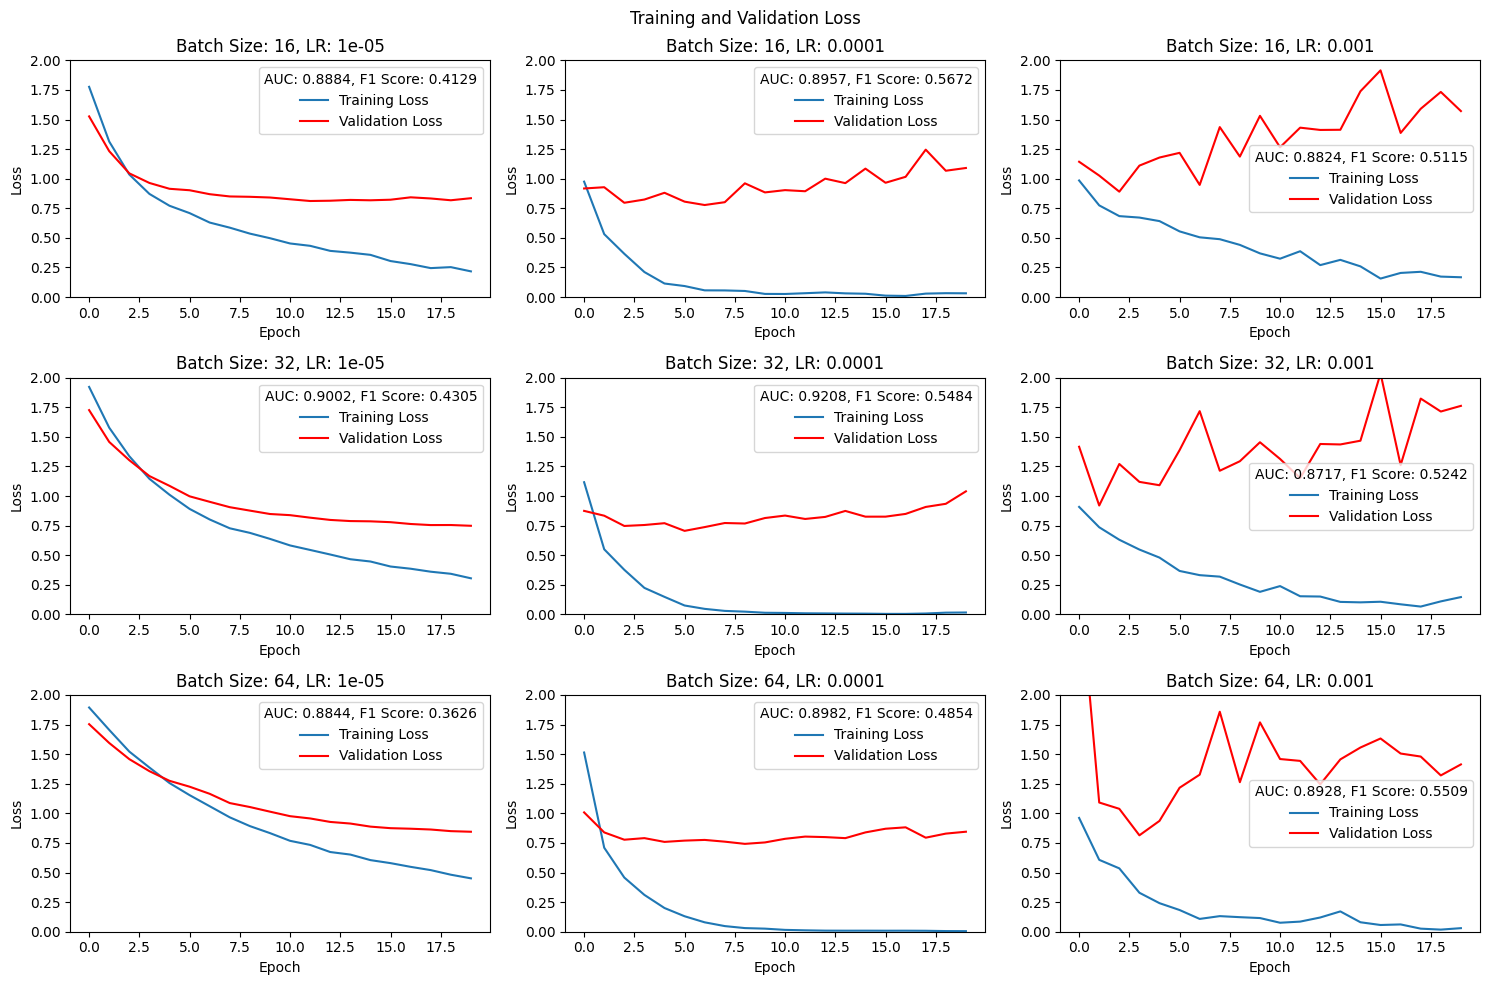

In [10]:
batch_sizes = [16, 32, 64]
learning_rates = [0.00001, 0.0001, 0.001] 

fig, axs = plt.subplots(len(batch_sizes), len(learning_rates), figsize=(15, 10))
plt.suptitle('Training and Validation Loss')

for i, batch_size in enumerate(batch_sizes):
    for j, learning_rate in enumerate(learning_rates):
        axs[i,j].plot(loss_dicts[i][j]['train'], label='Training Loss')
        axs[i,j].plot(loss_dicts[i][j]['validate'], label='Validation Loss', color='red')
        axs[i,j].set_title(f'Batch Size: {batch_size}, LR: {learning_rate}')
        axs[i,j].set_xlabel('Epoch')
        axs[i,j].set_ylabel('Loss')
        axs[i,j].set_ylim(0,2)
        axs[i, j].legend(title=f'AUC: {val_auc[i][j]:.4f}, F1 Score: {val_f1[i][j]:.4f}')

plt.tight_layout()
plt.savefig('MobileNetV2_Models_F1/hyperparameter_tuning_loss_mobilenetv2.png')
plt.show()

## Full Data: Dataset and DataLoader

In [11]:
best_bs_pretrained = 16
best_lr_pretrained = 0.0001

train_df_path = 'train.csv'
val_df_path = 'validation.csv'
test_df_path = 'test.csv'
root_image_directory = '/vast/amh9750/DL4MED_Project/DL4MED_Data/HAM10000/SkinCancer/Images'

mobilenetv2_transformed_dataset = {'train': HAM10000Dataset(train_df_path, root_image_directory, train_transform),
                       'validate': HAM10000Dataset(val_df_path, root_image_directory, validation_transform),
                        'test': HAM10000Dataset(test_df_path, root_image_directory, validation_transform)}
mobilenetv2_dataloader = {x: DataLoader(mobilenetv2_transformed_dataset[x], batch_size=best_bs_pretrained, shuffle=True) for x in ['train', 'validate','test']}

## Experiment 1-1: Training From Scratch

In [12]:
# MobileNetV2 model from scratch
class MobileNetV2Scratch(nn.Module):
    def __init__(self, num_classes=7):
        super(MobileNetV2Scratch, self).__init__()
        self.mobilenet_v2 = models.mobilenet_v2(pretrained=False)
        num_ftrs = self.mobilenet_v2.classifier[-1].in_features
        self.mobilenet_v2.classifier[-1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.mobilenet_v2(x)

In [13]:
mobilenetv2_model_1 = MobileNetV2Scratch().to(device)
loss_fn = nn.CrossEntropyLoss()
mobilenetv2_optimizer_1 = optim.Adam(mobilenetv2_model_1.parameters(), lr=best_lr_pretrained) 

/ext3/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ext3/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [14]:
mobilenetv2_model_out_1, mobilenetv2_f1_dict_1, mobilenetv2_loss_dict_1 = train_model(mobilenetv2_model_1, 
                                                                                       mobilenetv2_dataloader, 
                                                                                       mobilenetv2_optimizer_1, 
                                                                                       loss_fn, 
                                                                                       num_epochs=20, 
                                                                                       verbose = True)

# Save with pickle
with open('MobileNetV2_Models_F1/mobilenetv2_model_outputs_1_2.pkl', 'wb') as f:
    pickle.dump((mobilenetv2_f1_dict_1, mobilenetv2_loss_dict_1), f)

# Save with torch
torch.save(mobilenetv2_model_out_1.state_dict(), 'MobileNetV2_Models_F1/mobilenetv2_model_weights_1_2.pth')
torch.save(mobilenetv2_model_out_1, 'MobileNetV2_Models_F1/mobilenetv2_model_1_2.pth')

Epoch: 0/19
----------
Phase:train, epoch loss: 0.9874 Acc: 0.6653 F1: 0.1646
Phase:validate, epoch loss: 0.8903 Acc: 0.6879 F1: 0.2018
Epoch: 1/19
----------
Phase:train, epoch loss: 0.8670 Acc: 0.6781 F1: 0.2206
Phase:validate, epoch loss: 0.8298 Acc: 0.7000 F1: 0.2554
Epoch: 2/19
----------
Phase:train, epoch loss: 0.8239 Acc: 0.6905 F1: 0.2919
Phase:validate, epoch loss: 0.8369 Acc: 0.7010 F1: 0.2672
Epoch: 3/19
----------
Phase:train, epoch loss: 0.7734 Acc: 0.7070 F1: 0.3550
Phase:validate, epoch loss: 0.8604 Acc: 0.7081 F1: 0.3567
Epoch: 4/19
----------
Phase:train, epoch loss: 0.7544 Acc: 0.7172 F1: 0.3900
Phase:validate, epoch loss: 0.8077 Acc: 0.7111 F1: 0.3196
Epoch: 5/19
----------
Phase:train, epoch loss: 0.7246 Acc: 0.7300 F1: 0.4225
Phase:validate, epoch loss: 0.8454 Acc: 0.7323 F1: 0.3390
Epoch: 6/19
----------
Phase:train, epoch loss: 0.7029 Acc: 0.7401 F1: 0.4420
Phase:validate, epoch loss: 0.8328 Acc: 0.7071 F1: 0.3545
Epoch: 7/19
----------
Phase:train, epoch loss: 

## Experiment 1-2: Finetuning - Updating Pretrained Weights

In [15]:
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=7):
        super(MobileNetV2, self).__init__()
        self.mobilenet_v2 = models.mobilenet_v2(weights='IMAGENET1K_V1')
        num_ftrs = self.mobilenet_v2.classifier[-1].in_features
        self.mobilenet_v2.classifier[-1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.mobilenet_v2(x)

In [16]:
mobilenetv2_model_2 = MobileNetV2().to(device)
loss_fn = nn.CrossEntropyLoss()
mobilenetv2_optimizer_2 = optim.Adam(mobilenetv2_model_2.parameters(), lr=best_lr_pretrained) 

In [17]:
mobilenetv2_model_out_2, mobilenetv2_f1_dict_2, mobilenetv2_loss_dict_2 = train_model(mobilenetv2_model_2, 
                                                                                       mobilenetv2_dataloader, 
                                                                                       mobilenetv2_optimizer_2, 
                                                                                       loss_fn, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('MobileNetV2_Models_F1/mobilenetv2_model_outputs_2_2.pkl', 'wb') as f:
    pickle.dump((mobilenetv2_f1_dict_2, mobilenetv2_loss_dict_2), f)

# Save with torch
torch.save(mobilenetv2_model_out_2.state_dict(), 'MobileNetV2_Models_F1/mobilenetv2_model_weights_2_2.pth')
torch.save(mobilenetv2_model_out_2, 'MobileNetV2_Models_F1/mobilenetv2_model_2_2.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 0.6531 Acc: 0.7716 F1: 0.4852
Phase:validate, epoch loss: 0.5474 Acc: 0.8253 F1: 0.5558
Epoch: 1/14
----------
Phase:train, epoch loss: 0.4069 Acc: 0.8457 F1: 0.7215
Phase:validate, epoch loss: 0.4741 Acc: 0.8323 F1: 0.6419
Epoch: 2/14
----------
Phase:train, epoch loss: 0.2740 Acc: 0.9056 F1: 0.8393
Phase:validate, epoch loss: 0.4873 Acc: 0.8424 F1: 0.6542
Epoch: 3/14
----------
Phase:train, epoch loss: 0.1879 Acc: 0.9347 F1: 0.8974
Phase:validate, epoch loss: 0.5024 Acc: 0.8343 F1: 0.6277
Epoch: 4/14
----------
Phase:train, epoch loss: 0.1230 Acc: 0.9573 F1: 0.9328
Phase:validate, epoch loss: 0.6228 Acc: 0.8222 F1: 0.5860
Epoch: 5/14
----------
Phase:train, epoch loss: 0.0756 Acc: 0.9751 F1: 0.9681
Phase:validate, epoch loss: 0.6110 Acc: 0.8333 F1: 0.6012
Epoch: 6/14
----------
Phase:train, epoch loss: 0.0727 Acc: 0.9763 F1: 0.9679
Phase:validate, epoch loss: 0.6964 Acc: 0.8121 F1: 0.6427
Epoch: 7/14
----------
Phase:train, epoch loss: 

## Experiment 1-3: Linear Probing

In [18]:
class MobileNetV2LP(nn.Module):
    def __init__(self, num_classes=7):
        super(MobileNetV2LP, self).__init__()
        self.mobilenet_v2 = models.mobilenet_v2(weights='IMAGENET1K_V1')
        for param in self.mobilenet_v2.parameters():
            param.requires_grad = False
        num_ftrs = self.mobilenet_v2.classifier[-1].in_features
        self.mobilenet_v2.classifier[-1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.mobilenet_v2(x)

In [19]:
mobilenetv2_model_3 = MobileNetV2LP().to(device)
loss_fn = nn.CrossEntropyLoss()
mobilenetv2_optimizer_3 = optim.Adam(mobilenetv2_model_3.parameters(), lr=best_lr_pretrained) 

In [20]:
mobilenetv2_model_out_3, mobilenetv2_f1_dict_3, mobilenetv2_loss_dict_3 = train_model(mobilenetv2_model_3, 
                                                                                       mobilenetv2_dataloader, 
                                                                                       mobilenetv2_optimizer_3, 
                                                                                       loss_fn, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('MobileNetV2_Models_F1/mobilenetv2_model_outputs_3.pkl', 'wb') as f:
    pickle.dump((mobilenetv2_f1_dict_3, mobilenetv2_loss_dict_3), f)

# Save with torch
torch.save(mobilenetv2_model_out_3.state_dict(), 'MobileNetV2_Models_F1/mobilenetv2_model_weights_3.pth')
torch.save(mobilenetv2_model_out_3, 'MobileNetV2_Models_F1/mobilenetv2_model_3.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 1.0306 Acc: 0.6619 F1: 0.1294
Phase:validate, epoch loss: 0.8616 Acc: 0.7111 F1: 0.1498
Epoch: 1/14
----------
Phase:train, epoch loss: 0.8764 Acc: 0.6923 F1: 0.2042
Phase:validate, epoch loss: 0.7863 Acc: 0.7273 F1: 0.2154
Epoch: 2/14
----------
Phase:train, epoch loss: 0.8184 Acc: 0.7034 F1: 0.2473
Phase:validate, epoch loss: 0.7444 Acc: 0.7384 F1: 0.3122
Epoch: 3/14
----------
Phase:train, epoch loss: 0.7748 Acc: 0.7199 F1: 0.2956
Phase:validate, epoch loss: 0.7181 Acc: 0.7505 F1: 0.3505
Epoch: 4/14
----------
Phase:train, epoch loss: 0.7468 Acc: 0.7257 F1: 0.3196
Phase:validate, epoch loss: 0.7008 Acc: 0.7505 F1: 0.3550
Epoch: 5/14
----------
Phase:train, epoch loss: 0.7292 Acc: 0.7354 F1: 0.3518
Phase:validate, epoch loss: 0.6856 Acc: 0.7566 F1: 0.3812
Epoch: 6/14
----------
Phase:train, epoch loss: 0.7172 Acc: 0.7347 F1: 0.3656
Phase:validate, epoch loss: 0.6728 Acc: 0.7616 F1: 0.4309
Epoch: 7/14
----------
Phase:train, epoch loss: 

## Experiment 2: Finetuning with Data Augmentation

### Experiment 2-1: 

In [24]:
# Augmentation transform
augmentation_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(299), 
    transforms.RandomHorizontalFlip(), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [25]:
mobilenetv2_augmented_dataset = {'train': HAM10000Dataset(train_df_path, root_image_directory, augmentation_transform),
                       'validate': HAM10000Dataset(val_df_path, root_image_directory, validation_transform),
                        'test': HAM10000Dataset(test_df_path, root_image_directory, validation_transform)}
mobilenetv2_augmented_dataloader = {x: DataLoader(mobilenetv2_augmented_dataset[x], batch_size=best_bs_pretrained, shuffle=True) for x in ['train', 'validate','test']}

In [26]:
mobilenetv2_model_5 = MobileNetV2().to(device)
loss_fn = nn.CrossEntropyLoss()
mobilenetv2_optimizer_5 = optim.Adam(mobilenetv2_model_5.parameters(), lr=best_lr_pretrained) 

In [27]:
mobilenetv2_model_out_5, mobilenetv2_f1_dict_5, mobilenetv2_loss_dict_5 = train_model(mobilenetv2_model_5, 
                                                                                       mobilenetv2_augmented_dataloader, 
                                                                                       mobilenetv2_optimizer_5, 
                                                                                       loss_fn, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('MobileNetV2_Models_F1/mobilenetv2_model_outputs_5.pkl', 'wb') as f:
    pickle.dump((mobilenetv2_f1_dict_5, mobilenetv2_loss_dict_5), f)

# Save with torch
torch.save(mobilenetv2_model_out_5.state_dict(), 'MobileNetV2_Models_F1/mobilenetv2_model_weights_5.pth')
torch.save(mobilenetv2_model_out_5, 'MobileNetV2_Models_F1/mobilenetv2_model_5.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 0.8286 Acc: 0.7065 F1: 0.3194
Phase:validate, epoch loss: 0.6312 Acc: 0.7838 F1: 0.4384
Epoch: 1/14
----------
Phase:train, epoch loss: 0.6723 Acc: 0.7533 F1: 0.4584
Phase:validate, epoch loss: 0.5574 Acc: 0.8101 F1: 0.5146
Epoch: 2/14
----------
Phase:train, epoch loss: 0.6137 Acc: 0.7768 F1: 0.5417
Phase:validate, epoch loss: 0.5947 Acc: 0.8101 F1: 0.5955
Epoch: 3/14
----------
Phase:train, epoch loss: 0.5678 Acc: 0.7935 F1: 0.5960
Phase:validate, epoch loss: 0.5357 Acc: 0.8172 F1: 0.6204
Epoch: 4/14
----------
Phase:train, epoch loss: 0.5407 Acc: 0.7984 F1: 0.6059
Phase:validate, epoch loss: 0.5551 Acc: 0.8081 F1: 0.5711
Epoch: 5/14
----------
Phase:train, epoch loss: 0.5214 Acc: 0.8075 F1: 0.6314
Phase:validate, epoch loss: 0.4965 Acc: 0.8293 F1: 0.6649
Epoch: 6/14
----------
Phase:train, epoch loss: 0.5079 Acc: 0.8095 F1: 0.6494
Phase:validate, epoch loss: 0.4985 Acc: 0.8394 F1: 0.6694
Epoch: 7/14
----------
Phase:train, epoch loss: 

### Experiment 2-2:

In [28]:
# Augmentation transform
augmentation_transform_2 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(299), 
    transforms.RandomHorizontalFlip(), 
    transforms.ColorJitter(brightness=0.7, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [29]:
mobilenetv2_augmented_dataset_2 = {'train': HAM10000Dataset(train_df_path, root_image_directory, augmentation_transform_2),
                       'validate': HAM10000Dataset(val_df_path, root_image_directory, validation_transform),
                        'test': HAM10000Dataset(test_df_path, root_image_directory, validation_transform)}
mobilenetv2_augmented_dataloader_2 = {x: DataLoader(mobilenetv2_augmented_dataset_2[x], batch_size=best_bs_pretrained, shuffle=True) for x in ['train', 'validate','test']}

In [30]:
mobilenetv2_model_5_2 = MobileNetV2().to(device)
loss_fn = nn.CrossEntropyLoss()
mobilenetv2_optimizer_5_2 = optim.Adam(mobilenetv2_model_5_2.parameters(), lr=best_lr_pretrained) 

In [31]:
mobilenetv2_model_out_5_2, mobilenetv2_f1_dict_5_2, mobilenetv2_loss_dict_5_2 = train_model(mobilenetv2_model_5_2, 
                                                                                       mobilenetv2_augmented_dataloader_2, 
                                                                                       mobilenetv2_optimizer_5_2, 
                                                                                       loss_fn, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('MobileNetV2_Models_F1/mobilenetv2_model_outputs_5_2.pkl', 'wb') as f:
    pickle.dump((mobilenetv2_f1_dict_5_2, mobilenetv2_loss_dict_5_2), f)

# Save with torch
torch.save(mobilenetv2_model_out_5_2.state_dict(), 'MobileNetV2_Models_F1/mobilenetv2_model_weights_5_2.pth')
torch.save(mobilenetv2_model_out_5_2, 'MobileNetV2_Models_F1/mobilenetv2_model_5_2.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 0.8657 Acc: 0.6980 F1: 0.3018
Phase:validate, epoch loss: 0.6394 Acc: 0.7838 F1: 0.4857
Epoch: 1/14
----------
Phase:train, epoch loss: 0.7156 Acc: 0.7418 F1: 0.4274
Phase:validate, epoch loss: 0.6017 Acc: 0.7859 F1: 0.5147
Epoch: 2/14
----------
Phase:train, epoch loss: 0.6594 Acc: 0.7574 F1: 0.4932
Phase:validate, epoch loss: 0.5639 Acc: 0.8010 F1: 0.5550
Epoch: 3/14
----------
Phase:train, epoch loss: 0.6210 Acc: 0.7742 F1: 0.5446
Phase:validate, epoch loss: 0.5626 Acc: 0.8091 F1: 0.5396
Epoch: 4/14
----------
Phase:train, epoch loss: 0.5912 Acc: 0.7853 F1: 0.5570
Phase:validate, epoch loss: 0.5455 Acc: 0.8010 F1: 0.5753
Epoch: 5/14
----------
Phase:train, epoch loss: 0.5678 Acc: 0.7954 F1: 0.6089
Phase:validate, epoch loss: 0.5321 Acc: 0.8212 F1: 0.6194
Epoch: 6/14
----------
Phase:train, epoch loss: 0.5440 Acc: 0.8041 F1: 0.6177
Phase:validate, epoch loss: 0.5233 Acc: 0.8101 F1: 0.6247
Epoch: 7/14
----------
Phase:train, epoch loss: 

### Experiment 2-3

In [32]:
# Augmentation transform
augmentation_transform_3 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(299), 
    transforms.RandomHorizontalFlip(), 
    transforms.ColorJitter(brightness=0.2, contrast=0.7, saturation=0.2, hue=0.1), 
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [33]:
mobilenetv2_augmented_dataset_3 = {'train': HAM10000Dataset(train_df_path, root_image_directory, augmentation_transform_3),
                       'validate': HAM10000Dataset(val_df_path, root_image_directory, validation_transform),
                        'test': HAM10000Dataset(test_df_path, root_image_directory, validation_transform)}
mobilenetv2_augmented_dataloader_3 = {x: DataLoader(mobilenetv2_augmented_dataset_3[x], batch_size=best_bs_pretrained, shuffle=True) for x in ['train', 'validate','test']}

In [34]:
mobilenetv2_model_5_3 = MobileNetV2().to(device)
loss_fn = nn.CrossEntropyLoss()
mobilenetv2_optimizer_5_3 = optim.Adam(mobilenetv2_model_5_3.parameters(), lr=best_lr_pretrained) 

In [35]:
mobilenetv2_model_out_5_3, mobilenetv2_f1_dict_5_3, mobilenetv2_loss_dict_5_3 = train_model(mobilenetv2_model_5_3, 
                                                                                       mobilenetv2_augmented_dataloader_3, 
                                                                                       mobilenetv2_optimizer_5_3, 
                                                                                       loss_fn, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('MobileNetV2_Models_F1/mobilenetv2_model_outputs_5_3.pkl', 'wb') as f:
    pickle.dump((mobilenetv2_f1_dict_5_3, mobilenetv2_loss_dict_5_3), f)

# Save with torch
torch.save(mobilenetv2_model_out_5_3.state_dict(), 'MobileNetV2_Models_F1/mobilenetv2_model_weights_5_3.pth')
torch.save(mobilenetv2_model_out_5_3, 'MobileNetV2_Models_F1/mobilenetv2_model_5_3.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 0.8593 Acc: 0.6983 F1: 0.2844
Phase:validate, epoch loss: 0.6429 Acc: 0.7677 F1: 0.4092
Epoch: 1/14
----------
Phase:train, epoch loss: 0.7074 Acc: 0.7436 F1: 0.4370
Phase:validate, epoch loss: 0.5829 Acc: 0.8051 F1: 0.5480
Epoch: 2/14
----------
Phase:train, epoch loss: 0.6492 Acc: 0.7593 F1: 0.4972
Phase:validate, epoch loss: 0.5630 Acc: 0.7990 F1: 0.5586
Epoch: 3/14
----------
Phase:train, epoch loss: 0.6100 Acc: 0.7772 F1: 0.5478
Phase:validate, epoch loss: 0.5454 Acc: 0.8040 F1: 0.5600
Epoch: 4/14
----------
Phase:train, epoch loss: 0.5905 Acc: 0.7830 F1: 0.5690
Phase:validate, epoch loss: 0.5394 Acc: 0.8172 F1: 0.6170
Epoch: 5/14
----------
Phase:train, epoch loss: 0.5440 Acc: 0.8049 F1: 0.6181
Phase:validate, epoch loss: 0.5198 Acc: 0.8343 F1: 0.6654
Epoch: 6/14
----------
Phase:train, epoch loss: 0.5404 Acc: 0.8056 F1: 0.6406
Phase:validate, epoch loss: 0.5094 Acc: 0.8293 F1: 0.6464
Epoch: 7/14
----------
Phase:train, epoch loss: 

### Experiment 2-4

In [36]:
# Augmentation transform
augmentation_transform_4 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(299), 
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [37]:
mobilenetv2_augmented_dataset_4 = {'train': HAM10000Dataset(train_df_path, root_image_directory, augmentation_transform_4),
                       'validate': HAM10000Dataset(val_df_path, root_image_directory, validation_transform),
                        'test': HAM10000Dataset(test_df_path, root_image_directory, validation_transform)}
mobilenetv2_augmented_dataloader_4 = {x: DataLoader(mobilenetv2_augmented_dataset_4[x], batch_size=best_bs_pretrained, shuffle=True) for x in ['train', 'validate','test']}

In [38]:
mobilenetv2_model_5_4 = MobileNetV2().to(device)
loss_fn = nn.CrossEntropyLoss()
mobilenetv2_optimizer_5_4 = optim.Adam(mobilenetv2_model_5_4.parameters(), lr=best_lr_pretrained) 

In [39]:
mobilenetv2_model_out_5_4, mobilenetv2_f1_dict_5_4, mobilenetv2_loss_dict_5_4 = train_model(mobilenetv2_model_5_4, 
                                                                                       mobilenetv2_augmented_dataloader_4, 
                                                                                       mobilenetv2_optimizer_5_4, 
                                                                                       loss_fn, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('MobileNetV2_Models_F1/mobilenetv2_model_outputs_5_4.pkl', 'wb') as f:
    pickle.dump((mobilenetv2_f1_dict_5_4, mobilenetv2_loss_dict_5_4), f)

# Save with torch
torch.save(mobilenetv2_model_out_5_4.state_dict(), 'MobileNetV2_Models_F1/mobilenetv2_model_weights_5_4.pth')
torch.save(mobilenetv2_model_out_5_4, 'MobileNetV2_Models_F1/mobilenetv2_model_5_4.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 0.7323 Acc: 0.7395 F1: 0.4030
Phase:validate, epoch loss: 0.5698 Acc: 0.7939 F1: 0.5084
Epoch: 1/14
----------
Phase:train, epoch loss: 0.5766 Acc: 0.7871 F1: 0.5651
Phase:validate, epoch loss: 0.5401 Acc: 0.8071 F1: 0.5986
Epoch: 2/14
----------
Phase:train, epoch loss: 0.5227 Acc: 0.8080 F1: 0.6436
Phase:validate, epoch loss: 0.4828 Acc: 0.8293 F1: 0.6535
Epoch: 3/14
----------
Phase:train, epoch loss: 0.4675 Acc: 0.8295 F1: 0.6839
Phase:validate, epoch loss: 0.4680 Acc: 0.8475 F1: 0.6540
Epoch: 4/14
----------
Phase:train, epoch loss: 0.4355 Acc: 0.8436 F1: 0.7197
Phase:validate, epoch loss: 0.4716 Acc: 0.8404 F1: 0.6997
Epoch: 5/14
----------
Phase:train, epoch loss: 0.3987 Acc: 0.8582 F1: 0.7473
Phase:validate, epoch loss: 0.4694 Acc: 0.8444 F1: 0.7062
Epoch: 6/14
----------
Phase:train, epoch loss: 0.3968 Acc: 0.8534 F1: 0.7462
Phase:validate, epoch loss: 0.4905 Acc: 0.8455 F1: 0.6805
Epoch: 7/14
----------
Phase:train, epoch loss: 

## Experiment 3: Finetuning with Weight Decay

### Experiment 3-1: 1e-5

In [40]:
mobilenetv2_model_6 = MobileNetV2().to(device)
loss_fn = nn.CrossEntropyLoss()
mobilenetv2_optimizer_6 = optim.Adam(mobilenetv2_model_6.parameters(), lr=best_lr_pretrained, weight_decay=1e-5) 

In [41]:
mobilenetv2_model_out_6, mobilenetv2_f1_dict_6, mobilenetv2_loss_dict_6 = train_model(mobilenetv2_model_6, 
                                                                                       mobilenetv2_dataloader, 
                                                                                       mobilenetv2_optimizer_6, 
                                                                                       loss_fn, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('MobileNetV2_Models_F1/mobilenetv2_model_outputs_6.pkl', 'wb') as f:
    pickle.dump((mobilenetv2_f1_dict_6, mobilenetv2_loss_dict_6), f)

# Save with torch
torch.save(mobilenetv2_model_out_6.state_dict(), 'MobileNetV2_Models_F1/mobilenetv2_model_weights_6.pth')
torch.save(mobilenetv2_model_out_6, 'MobileNetV2_Models_F1/mobilenetv2_model_6.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 0.6831 Acc: 0.7532 F1: 0.4555
Phase:validate, epoch loss: 0.4955 Acc: 0.8192 F1: 0.5712
Epoch: 1/14
----------
Phase:train, epoch loss: 0.4275 Acc: 0.8410 F1: 0.6921
Phase:validate, epoch loss: 0.5028 Acc: 0.8323 F1: 0.6112
Epoch: 2/14
----------
Phase:train, epoch loss: 0.2869 Acc: 0.8959 F1: 0.8279
Phase:validate, epoch loss: 0.4973 Acc: 0.8283 F1: 0.6574
Epoch: 3/14
----------
Phase:train, epoch loss: 0.1785 Acc: 0.9360 F1: 0.9017
Phase:validate, epoch loss: 0.5255 Acc: 0.8525 F1: 0.6904
Epoch: 4/14
----------
Phase:train, epoch loss: 0.1133 Acc: 0.9595 F1: 0.9385
Phase:validate, epoch loss: 0.5827 Acc: 0.8263 F1: 0.6525
Epoch: 5/14
----------
Phase:train, epoch loss: 0.0897 Acc: 0.9691 F1: 0.9478
Phase:validate, epoch loss: 0.5881 Acc: 0.8424 F1: 0.6752
Epoch: 6/14
----------
Phase:train, epoch loss: 0.0702 Acc: 0.9774 F1: 0.9709
Phase:validate, epoch loss: 0.6575 Acc: 0.8343 F1: 0.6706
Epoch: 7/14
----------
Phase:train, epoch loss: 

### Experiment 3-2: 1e-4

In [42]:
mobilenetv2_model_6_2 = MobileNetV2().to(device)
loss_fn = nn.CrossEntropyLoss()
mobilenetv2_optimizer_6_2 = optim.Adam(mobilenetv2_model_6_2.parameters(), lr=best_lr_pretrained, weight_decay=1e-4) 

In [43]:
mobilenetv2_model_out_6_2, mobilenetv2_f1_dict_6_2, mobilenetv2_loss_dict_6_2 = train_model(mobilenetv2_model_6_2, 
                                                                                       mobilenetv2_dataloader, 
                                                                                       mobilenetv2_optimizer_6_2, 
                                                                                       loss_fn, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('MobileNetV2_Models_F1/mobilenetv2_model_outputs_6_2.pkl', 'wb') as f:
    pickle.dump((mobilenetv2_f1_dict_6_2, mobilenetv2_loss_dict_6_2), f)

# Save with torch
torch.save(mobilenetv2_model_out_6_2.state_dict(), 'MobileNetV2_Models_F1/mobilenetv2_model_weights_6_2.pth')
torch.save(mobilenetv2_model_out_6_2, 'MobileNetV2_Models_F1/mobilenetv2_model_6_2.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 0.6611 Acc: 0.7587 F1: 0.4587
Phase:validate, epoch loss: 0.5044 Acc: 0.8283 F1: 0.6103
Epoch: 1/14
----------
Phase:train, epoch loss: 0.4167 Acc: 0.8464 F1: 0.7074
Phase:validate, epoch loss: 0.4852 Acc: 0.8313 F1: 0.6164
Epoch: 2/14
----------
Phase:train, epoch loss: 0.2859 Acc: 0.8989 F1: 0.8281
Phase:validate, epoch loss: 0.5031 Acc: 0.8404 F1: 0.6599
Epoch: 3/14
----------
Phase:train, epoch loss: 0.1884 Acc: 0.9320 F1: 0.8946
Phase:validate, epoch loss: 0.5742 Acc: 0.8172 F1: 0.6447
Epoch: 4/14
----------
Phase:train, epoch loss: 0.1310 Acc: 0.9576 F1: 0.9338
Phase:validate, epoch loss: 0.6217 Acc: 0.8394 F1: 0.6423
Epoch: 5/14
----------
Phase:train, epoch loss: 0.0899 Acc: 0.9694 F1: 0.9568
Phase:validate, epoch loss: 0.6944 Acc: 0.8212 F1: 0.6237
Epoch: 6/14
----------
Phase:train, epoch loss: 0.0727 Acc: 0.9763 F1: 0.9696
Phase:validate, epoch loss: 0.6475 Acc: 0.8303 F1: 0.6561
Epoch: 7/14
----------
Phase:train, epoch loss: 

### Experiment 3-3: 1e-6

In [44]:
mobilenetv2_model_6_3 = MobileNetV2().to(device)
loss_fn = nn.CrossEntropyLoss()
mobilenetv2_optimizer_6_3 = optim.Adam(mobilenetv2_model_6_3.parameters(), lr=best_lr_pretrained, weight_decay=1e-6) 

In [45]:
mobilenetv2_model_out_6_3, mobilenetv2_f1_dict_6_3, mobilenetv2_loss_dict_6_3 = train_model(mobilenetv2_model_6_3, 
                                                                                       mobilenetv2_dataloader, 
                                                                                       mobilenetv2_optimizer_6_3, 
                                                                                       loss_fn, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('MobileNetV2_Models_F1/mobilenetv2_model_outputs_6_3.pkl', 'wb') as f:
    pickle.dump((mobilenetv2_f1_dict_6_3, mobilenetv2_loss_dict_6_3), f)

# Save with torch
torch.save(mobilenetv2_model_out_6_3.state_dict(), 'MobileNetV2_Models_F1/mobilenetv2_model_weights_6_3.pth')
torch.save(mobilenetv2_model_out_6_3, 'MobileNetV2_Models_F1/mobilenetv2_model_6_3.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 0.6785 Acc: 0.7600 F1: 0.4712
Phase:validate, epoch loss: 0.5176 Acc: 0.8212 F1: 0.5823
Epoch: 1/14
----------
Phase:train, epoch loss: 0.4221 Acc: 0.8504 F1: 0.6966
Phase:validate, epoch loss: 0.4711 Acc: 0.8323 F1: 0.6098
Epoch: 2/14
----------
Phase:train, epoch loss: 0.2999 Acc: 0.8921 F1: 0.8053
Phase:validate, epoch loss: 0.5149 Acc: 0.8263 F1: 0.6270
Epoch: 3/14
----------
Phase:train, epoch loss: 0.1948 Acc: 0.9326 F1: 0.8849
Phase:validate, epoch loss: 0.5447 Acc: 0.8323 F1: 0.6254
Epoch: 4/14
----------
Phase:train, epoch loss: 0.1288 Acc: 0.9571 F1: 0.9355
Phase:validate, epoch loss: 0.5954 Acc: 0.8404 F1: 0.6662
Epoch: 5/14
----------
Phase:train, epoch loss: 0.0972 Acc: 0.9677 F1: 0.9466
Phase:validate, epoch loss: 0.5959 Acc: 0.8384 F1: 0.6769
Epoch: 6/14
----------
Phase:train, epoch loss: 0.0837 Acc: 0.9723 F1: 0.9606
Phase:validate, epoch loss: 0.6478 Acc: 0.8465 F1: 0.6609
Epoch: 7/14
----------
Phase:train, epoch loss: 

### Experiment 3-4: 1e-7

In [46]:
mobilenetv2_model_6_4 = MobileNetV2().to(device)
loss_fn = nn.CrossEntropyLoss()
mobilenetv2_optimizer_6_4 = optim.Adam(mobilenetv2_model_6_4.parameters(), lr=best_lr_pretrained, weight_decay=1e-7) 

In [47]:
mobilenetv2_model_out_6_4, mobilenetv2_f1_dict_6_4, mobilenetv2_loss_dict_6_4 = train_model(mobilenetv2_model_6_4, 
                                                                                       mobilenetv2_dataloader, 
                                                                                       mobilenetv2_optimizer_6_4, 
                                                                                       loss_fn, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('MobileNetV2_Models_F1/mobilenetv2_model_outputs_6_4.pkl', 'wb') as f:
    pickle.dump((mobilenetv2_f1_dict_6_4, mobilenetv2_loss_dict_6_4), f)

# Save with torch
torch.save(mobilenetv2_model_out_6_4.state_dict(), 'MobileNetV2_Models_F1/mobilenetv2_model_weights_6_4.pth')
torch.save(mobilenetv2_model_out_6_4, 'MobileNetV2_Models_F1/mobilenetv2_model_6_4.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 0.6760 Acc: 0.7586 F1: 0.4553
Phase:validate, epoch loss: 0.4854 Acc: 0.8404 F1: 0.6438
Epoch: 1/14
----------
Phase:train, epoch loss: 0.4062 Acc: 0.8541 F1: 0.7282
Phase:validate, epoch loss: 0.5643 Acc: 0.8111 F1: 0.5777
Epoch: 2/14
----------
Phase:train, epoch loss: 0.2692 Acc: 0.9008 F1: 0.8279
Phase:validate, epoch loss: 0.5189 Acc: 0.8253 F1: 0.6439
Epoch: 3/14
----------
Phase:train, epoch loss: 0.1809 Acc: 0.9366 F1: 0.8961
Phase:validate, epoch loss: 0.5356 Acc: 0.8444 F1: 0.6160
Epoch: 4/14
----------
Phase:train, epoch loss: 0.1279 Acc: 0.9566 F1: 0.9339
Phase:validate, epoch loss: 0.6518 Acc: 0.8263 F1: 0.6469
Epoch: 5/14
----------
Phase:train, epoch loss: 0.0814 Acc: 0.9737 F1: 0.9578
Phase:validate, epoch loss: 0.5834 Acc: 0.8444 F1: 0.6572
Epoch: 6/14
----------
Phase:train, epoch loss: 0.0735 Acc: 0.9767 F1: 0.9690
Phase:validate, epoch loss: 0.6550 Acc: 0.8303 F1: 0.6524
Epoch: 7/14
----------
Phase:train, epoch loss: 

## Experiment 4: Finetuning with Modified Loss Function 

### Experiment 4-1

In [48]:
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=7):
        super(MobileNetV2, self).__init__()
        self.mobilenet_v2 = models.mobilenet_v2(weights='IMAGENET1K_V1')
        num_ftrs = self.mobilenet_v2.classifier[-1].in_features
        self.mobilenet_v2.classifier[-1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.mobilenet_v2(x)

# Placing a higher weight on the cancerous classes
class_weights = torch.FloatTensor([5.0, 5.0, 1.0, 1.0, 5.0, 1.0, 1.0]).to(device)

In [49]:
mobilenetv2_model_7 = MobileNetV2().to(device)
loss_fn_7 = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')
mobilenetv2_optimizer_7 = optim.Adam(mobilenetv2_model_7.parameters(), lr=best_lr_pretrained) 

In [50]:
mobilenetv2_model_out_7, mobilenetv2_f1_dict_7, mobilenetv2_loss_dict_7 = train_model(mobilenetv2_model_7, 
                                                                                       mobilenetv2_dataloader, 
                                                                                       mobilenetv2_optimizer_7, 
                                                                                       loss_fn_7, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('MobileNetV2_Models_F1/mobilenetv2_model_outputs_7.pkl', 'wb') as f:
    pickle.dump((mobilenetv2_f1_dict_7, mobilenetv2_loss_dict_7), f)

# Save with torch
torch.save(mobilenetv2_model_out_7.state_dict(), 'MobileNetV2_Models_F1/mobilenetv2_model_weights_7.pth')
torch.save(mobilenetv2_model_out_7, 'MobileNetV2_Models_F1/mobilenetv2_model_7.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 0.8445 Acc: 0.6889 F1: 0.3842
Phase:validate, epoch loss: 0.6905 Acc: 0.7101 F1: 0.4616
Epoch: 1/14
----------
Phase:train, epoch loss: 0.5485 Acc: 0.7864 F1: 0.5727
Phase:validate, epoch loss: 0.6253 Acc: 0.7929 F1: 0.5696
Epoch: 2/14
----------
Phase:train, epoch loss: 0.3830 Acc: 0.8486 F1: 0.7263
Phase:validate, epoch loss: 0.6229 Acc: 0.8242 F1: 0.5962
Epoch: 3/14
----------
Phase:train, epoch loss: 0.2579 Acc: 0.8914 F1: 0.8050
Phase:validate, epoch loss: 0.7059 Acc: 0.7980 F1: 0.6094
Epoch: 4/14
----------
Phase:train, epoch loss: 0.1998 Acc: 0.9211 F1: 0.8613
Phase:validate, epoch loss: 0.8227 Acc: 0.7919 F1: 0.5722
Epoch: 5/14
----------
Phase:train, epoch loss: 0.1432 Acc: 0.9420 F1: 0.8962
Phase:validate, epoch loss: 0.8222 Acc: 0.8152 F1: 0.6194
Epoch: 6/14
----------
Phase:train, epoch loss: 0.1094 Acc: 0.9555 F1: 0.9285
Phase:validate, epoch loss: 0.8804 Acc: 0.8232 F1: 0.6055
Epoch: 7/14
----------
Phase:train, epoch loss: 

### Experiment 4-2:

In [51]:
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=7):
        super(MobileNetV2, self).__init__()
        self.mobilenet_v2 = models.mobilenet_v2(weights='IMAGENET1K_V1')
        num_ftrs = self.mobilenet_v2.classifier[-1].in_features
        self.mobilenet_v2.classifier[-1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.mobilenet_v2(x)

# Placing a higher weight on the cancerous classes
class_weights_2 = torch.FloatTensor([10.0, 10.0, 1.0, 1.0, 10.0, 1.0, 1.0]).to(device)

In [52]:
mobilenetv2_model_7_2 = MobileNetV2().to(device)
loss_fn_7_2 = nn.CrossEntropyLoss(weight=class_weights_2, reduction='mean')
mobilenetv2_optimizer_7_2 = optim.Adam(mobilenetv2_model_7_2.parameters(), lr=best_lr_pretrained) 

In [53]:
mobilenetv2_model_out_7_2, mobilenetv2_f1_dict_7_2, mobilenetv2_loss_dict_7_2 = train_model(mobilenetv2_model_7_2, 
                                                                                       mobilenetv2_dataloader, 
                                                                                       mobilenetv2_optimizer_7_2, 
                                                                                       loss_fn_7_2, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('MobileNetV2_Models_F1/mobilenetv2_model_outputs_7_2.pkl', 'wb') as f:
    pickle.dump((mobilenetv2_f1_dict_7_2, mobilenetv2_loss_dict_7_2), f)

# Save with torch
torch.save(mobilenetv2_model_out_7_2.state_dict(), 'MobileNetV2_Models_F1/mobilenetv2_model_weights_7_2.pth')
torch.save(mobilenetv2_model_out_7_2, 'MobileNetV2_Models_F1/mobilenetv2_model_7_2.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 0.8385 Acc: 0.6346 F1: 0.3301
Phase:validate, epoch loss: 0.6516 Acc: 0.6990 F1: 0.3977
Epoch: 1/14
----------
Phase:train, epoch loss: 0.5604 Acc: 0.7161 F1: 0.4664
Phase:validate, epoch loss: 0.6577 Acc: 0.7313 F1: 0.4292
Epoch: 2/14
----------
Phase:train, epoch loss: 0.3983 Acc: 0.7836 F1: 0.5911
Phase:validate, epoch loss: 0.5798 Acc: 0.7808 F1: 0.5628
Epoch: 3/14
----------
Phase:train, epoch loss: 0.3158 Acc: 0.8353 F1: 0.6708
Phase:validate, epoch loss: 0.6435 Acc: 0.7717 F1: 0.5549
Epoch: 4/14
----------
Phase:train, epoch loss: 0.2321 Acc: 0.8675 F1: 0.7561
Phase:validate, epoch loss: 0.7691 Acc: 0.8212 F1: 0.5706
Epoch: 5/14
----------
Phase:train, epoch loss: 0.1706 Acc: 0.8992 F1: 0.8056
Phase:validate, epoch loss: 0.6086 Acc: 0.7646 F1: 0.5745
Epoch: 6/14
----------
Phase:train, epoch loss: 0.1286 Acc: 0.9218 F1: 0.8595
Phase:validate, epoch loss: 0.7613 Acc: 0.8162 F1: 0.6287
Epoch: 7/14
----------
Phase:train, epoch loss: 

### Experiment 4-3:

In [54]:
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=7):
        super(MobileNetV2, self).__init__()
        self.mobilenet_v2 = models.mobilenet_v2(weights='IMAGENET1K_V1')
        num_ftrs = self.mobilenet_v2.classifier[-1].in_features
        self.mobilenet_v2.classifier[-1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.mobilenet_v2(x)
        
# Placing a higher weight on the cancerous classes
class_weights_3 = torch.FloatTensor([15.0, 15.0, 1.0, 1.0, 15.0, 1.0, 1.0]).to(device)

In [55]:
mobilenetv2_model_7_3 = MobileNetV2().to(device)
loss_fn_7_3 = nn.CrossEntropyLoss(weight=class_weights_3, reduction='mean')
mobilenetv2_optimizer_7_3 = optim.Adam(mobilenetv2_model_7_3.parameters(), lr=best_lr_pretrained) 

In [56]:
mobilenetv2_model_out_7_3, mobilenetv2_f1_dict_7_3, mobilenetv2_loss_dict_7_3 = train_model(mobilenetv2_model_7_3, 
                                                                                       mobilenetv2_dataloader, 
                                                                                       mobilenetv2_optimizer_7_3, 
                                                                                       loss_fn_7_3, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('MobileNetV2_Models_F1/mobilenetv2_model_outputs_7_3.pkl', 'wb') as f:
    pickle.dump((mobilenetv2_f1_dict_7_3, mobilenetv2_loss_dict_7_3), f)

# Save with torch
torch.save(mobilenetv2_model_out_7_3.state_dict(), 'MobileNetV2_Models_F1/mobilenetv2_model_weights_7_3.pth')
torch.save(mobilenetv2_model_out_7_3, 'MobileNetV2_Models_F1/mobilenetv2_model_7_3.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 0.8307 Acc: 0.5928 F1: 0.3049
Phase:validate, epoch loss: 0.6441 Acc: 0.6798 F1: 0.3855
Epoch: 1/14
----------
Phase:train, epoch loss: 0.5680 Acc: 0.6731 F1: 0.4282
Phase:validate, epoch loss: 0.6487 Acc: 0.6465 F1: 0.3765
Epoch: 2/14
----------
Phase:train, epoch loss: 0.4306 Acc: 0.7394 F1: 0.5333
Phase:validate, epoch loss: 0.6644 Acc: 0.7061 F1: 0.4892
Epoch: 3/14
----------
Phase:train, epoch loss: 0.3239 Acc: 0.7904 F1: 0.6052
Phase:validate, epoch loss: 0.5977 Acc: 0.7242 F1: 0.5122
Epoch: 4/14
----------
Phase:train, epoch loss: 0.2211 Acc: 0.8334 F1: 0.6987
Phase:validate, epoch loss: 0.8683 Acc: 0.7949 F1: 0.5835
Epoch: 5/14
----------
Phase:train, epoch loss: 0.1892 Acc: 0.8592 F1: 0.7401
Phase:validate, epoch loss: 0.8001 Acc: 0.7687 F1: 0.5931
Epoch: 6/14
----------
Phase:train, epoch loss: 0.1511 Acc: 0.8865 F1: 0.8249
Phase:validate, epoch loss: 0.9071 Acc: 0.7939 F1: 0.5853
Epoch: 7/14
----------
Phase:train, epoch loss: 

### Experiment 4-4

In [57]:
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=7):
        super(MobileNetV2, self).__init__()
        self.mobilenet_v2 = models.mobilenet_v2(weights='IMAGENET1K_V1')
        num_ftrs = self.mobilenet_v2.classifier[-1].in_features
        self.mobilenet_v2.classifier[-1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.mobilenet_v2(x)

# Placing a higher weight on the cancerous classes
class_weights_4 = torch.FloatTensor([3.0, 3.0, 1.0, 1.0, 3.0, 1.0, 1.0]).to(device)

In [58]:
mobilenetv2_model_7_4 = MobileNetV2().to(device)
loss_fn_7_4 = nn.CrossEntropyLoss(weight=class_weights_4, reduction='mean')
mobilenetv2_optimizer_7_4 = optim.Adam(mobilenetv2_model_7_4.parameters(), lr=best_lr_pretrained) 

In [59]:
mobilenetv2_model_out_7_4, mobilenetv2_f1_dict_7_4, mobilenetv2_loss_dict_7_4 = train_model(mobilenetv2_model_7_4, 
                                                                                       mobilenetv2_dataloader, 
                                                                                       mobilenetv2_optimizer_7_4, 
                                                                                       loss_fn_7_4, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('MobileNetV2_Models_F1/mobilenetv2_model_outputs_7_4.pkl', 'wb') as f:
    pickle.dump((mobilenetv2_f1_dict_7_4, mobilenetv2_loss_dict_7_4), f)

# Save with torch
torch.save(mobilenetv2_model_out_7_4.state_dict(), 'MobileNetV2_Models_F1/mobilenetv2_model_weights_7_4.pth')
torch.save(mobilenetv2_model_out_7_4, 'MobileNetV2_Models_F1/mobilenetv2_model_7_4.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 0.8151 Acc: 0.7243 F1: 0.4327
Phase:validate, epoch loss: 0.6816 Acc: 0.7949 F1: 0.5112
Epoch: 1/14
----------
Phase:train, epoch loss: 0.5189 Acc: 0.8166 F1: 0.6298
Phase:validate, epoch loss: 0.5843 Acc: 0.8202 F1: 0.6211
Epoch: 2/14
----------
Phase:train, epoch loss: 0.3702 Acc: 0.8732 F1: 0.7744
Phase:validate, epoch loss: 0.6140 Acc: 0.8293 F1: 0.6493
Epoch: 3/14
----------
Phase:train, epoch loss: 0.2296 Acc: 0.9221 F1: 0.8614
Phase:validate, epoch loss: 0.6359 Acc: 0.8172 F1: 0.6031
Epoch: 4/14
----------
Phase:train, epoch loss: 0.1713 Acc: 0.9414 F1: 0.8947
Phase:validate, epoch loss: 0.6548 Acc: 0.8333 F1: 0.6149
Epoch: 5/14
----------
Phase:train, epoch loss: 0.1231 Acc: 0.9573 F1: 0.9257
Phase:validate, epoch loss: 0.8290 Acc: 0.8293 F1: 0.6626
Epoch: 6/14
----------
Phase:train, epoch loss: 0.0901 Acc: 0.9714 F1: 0.9564
Phase:validate, epoch loss: 0.8510 Acc: 0.8293 F1: 0.6373
Epoch: 7/14
----------
Phase:train, epoch loss: 